# エグゼクティブサマリー
過去12件の出店データに基づき、階層ベイズモデルを用いて地点ごとの
- 売上ポテンシャル
- 天候リスク

を分離・評価しました。単純な平均値では判断できない「不確実性（リスク）」を可視化
し、ROI（投資対効果）に基づいた戦略的な判断材料を提供します。

## 事前準備
確率モデルの構築やデータ分析に必要なライブラリのインポートや独自カラー定義を行います。


In [1]:
# 不要な出力をしないように制御
import warnings

import matplotlib.pyplot as plt
import numpy as np
# 必要なライブラリの読み込み
import pandas as pd
import pymc as pm
import seaborn as sns

warnings.filterwarnings("ignore")

In [7]:
# プロジェクト共通のカラー定義
COLOR_PURPLE = "#985DE5"  # 事後分布・HDI
COLOR_YELLOW = "#F9C74F"  # ROPE 領域
COLOR_GREEN  = "#06D6A0"  # 改善判定
COLOR_RED    = "#EF476F"  # 悪化判定
COLOR_GRAY   = "#8D99AE"  # 等価判定・参照線

plt.rcdefaults()  # plt の現在のカラー定義をリセット
palette_brand = [COLOR_PURPLE, COLOR_YELLOW, COLOR_GREEN, COLOR_RED, COLOR_GRAY]

sns.set_theme(style="whitegrid", palette=palette_brand)
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=palette_brand)

print(f"Brand Style Applied: The visual identity was applied.")

Brand Style Applied: The visual identity was applied.


>#### Tips:
>分析結果のビジュアルを統一し、どのグラフを見ても「紫は実力、緑は成功」と直感的に理解できるようにしています。
>Color Cycle グラフを描画する際、色が指定されていない場合に自動的に適用される色の順番です。
> 最初は紫、次を黄色...と決めておくことで、毎回指定しなくても色が揃います。
>
>ビジネスレポートにおいて「色の意味」を固定することは、意思決定のスピードを高めます。
> 複数の Notebook を管理する実務現場では、これを共通モジュール化し、メンテナンス姓を高めることを推奨します。
>
>１番大事なことですが、**自分のお気に入りの配色にするとバイブス**が上がります。

## データの準備とホワイトボックス化
分析の原材料となるデータの読み込み、集計可能な数値型へ変換します。
今回は、１年分の簡単なデータが CSV で記録してあった、とします。

In [17]:
# データの読み込み（外部データより読み込み）
PATH_ROW_DATA = "sales_performance.csv"

df_raw = pd.read_csv(PATH_ROW_DATA)
df_raw

,出店日時,ロケーション,天気,売上実績 (sales_obs),固定費,歩合率
0,2025-04-15 08:00-17:00,A: 駅前広場,晴,"105,000","12,000",0.10
1,2025-05-20 08:00-17:00,A: 駅前広場,雨,"85,000","12,000",0.10
2,2025-06-10 08:00-17:00,A: 駅前広場,くもり,"98,000","12,000",0.10
3,2025-07-05 08:00-17:00,B: 公園通り,晴,"42,000","8,000",0.05
4,2025-08-12 08:00-17:00,B: 公園通り,晴,"38,000","8,000",0.05
5,2025-09-18 08:00-17:00,B: 公園通り,雨,"25,000","8,000",0.05
6,2025-10-02 08:00-17:00,C: ショッピングモール,晴,"72,000","15,000",0.00
7,2025-11-15 08:00-17:00,C: ショッピングモール,くもり,"65,000","15,000",0.00
8,2025-12-20 08:00-17:00,C: ショッピングモール,雪,"50,000","15,000",0.00
9,2025-01-10 08:00-17:00,D: 寺院境内,晴,"32,000","5,000",0.08


In [26]:
# 数値変換のクレンジング
df = pd.DataFrame()
df["sales_obs"]       = df_raw["売上実績 (sales_obs)"].str.replace(",", "").astype(float)
df["cost_fixed"]      = df_raw["固定費"].str.replace(",", "").astype(float)
df["commission_rate"] = df_raw["歩合率"]

# 読み込み直後のデータ確認
df

,sales_obs,cost_fixed,commission_rate
0,105000.0,12000.0,0.10
1,85000.0,12000.0,0.10
2,98000.0,12000.0,0.10
3,42000.0,8000.0,0.05
4,38000.0,8000.0,0.05
5,25000.0,8000.0,0.05
6,72000.0,15000.0,0.00
7,65000.0,15000.0,0.00
8,50000.0,15000.0,0.00
9,32000.0,5000.0,0.08


データクレンジングとは、カンマや型不整合などのノイズを取り除き、統計モデルが計算できる形に
整える工程です。

> ### tips:
> 生データのことを Raw Data と言います。よって `df_raw` という変数名にしています。
>
> データを `row` のまま保持することには以下のメリットがあります。
> 1. 再現性の確保
>     - 前処理のコード（洗浄工程）に間違いが見つかった際、いつでも初期状態の `df_raw` からやり直すことができます。
> 2. ベイズ推論への橋渡し
>       - PyMC5 での実装では、文字列（場所など）を数値インデックス（0, 1, 2, ...）に変換する工程が必須です。
>           `df_row` を残しておくことで、「インデックス０番はどの場所だったか？」という対応関係（Coords / Dims）をいつでも参照できます。


## 特徴量生成とインデックス化
「場所」や「天気」といった文字情報を、数式で扱える「背番号（インデックス）」に変換します。
また、日付から「季節」という売上に影響する重要な文脈を抽出します。

In [27]:
# 季節情報の抽出
df["opening_datetime"] = pd.to_datetime(df_raw["出店日時"].str.split(" ").str[0])
df["idx_month"] = df_raw["opening_datetime"].dt.month

In [28]:
def define_season(month: int) -> str:
    """
    与えられた月に基づいて季節を決定します。この関数は入力された月を評価し、春、夏、秋、冬の4つの季節のいずれかに分類します。

    :param month: 整数で表された月 (1 月は 1、2 月は 2、...、12 月は 12)。
    :type month: int
    :return: 指定された月に対応する季節の名前。
    :rtype: str
    """
    if month in [3, 4, 5]: return "Spring"
    if month in [6, 7, 8]: return "Summer"
    if month in [9, 10, 11]: return "Autumn"
    return "Winter"

In [29]:
df["season_label"] = df_raw["idx_month"].apply(define_season)

df["season_label"]

0     Spring
1     Spring
2     Summer
3     Summer
4     Summer
5     Autumn
6     Autumn
7     Autumn
8     Winter
9     Winter
10    Winter
11    Spring
Name: season_label, dtype: object

In [30]:
# カテゴリのインデックス化
df["idx_location"], locations = pd.factorize(df_raw["ロケーション"])
df["idx_weather"], weathers = pd.factorize(df_raw["天気"])
df["idx_season"], seasons = pd.factorize(df_raw["season_label"])

`pd.factorize()` は、ユニークな文字列に対して一意の整数を割り当てるラベルエンコーディング手法です。

In [31]:
# PyMC用座標定義
coords = {
    "location": locations,
    "weather": weathers,
    "season": seasons,
    "id_obs": np.arange(len(df))
}

print(f"Location Map: {list(enumerate(locations))}")

Location Map: [(0, 'A: 駅前広場'), (1, 'B: 公園通り'), (2, 'C: ショッピングモール'), (3, 'D: 寺院境内')]


「名前」ではなく「ID」で呼ぶようにします。あとで名簿（`locations`等）と突き合わせれば、
誰が誰だか分かります。

## 確率モデルの構築
売上に影響を与える「立地」「天気」「季節」を独立した変数として扱い、それぞれの影響度をベイズ線形回帰の枠組みで推定します。

In [38]:
with pm.Model(coords=coords) as hierarchical_bayesian_linear_regression_model:
    # 入力データ
    idx_location = pm.Data("idx_location", df["idx_location"], dims="id_obs")  # 各観測データに対応する地点ID
    idx_weather = pm.Data("idx_weather", df["idx_weather"], dims="id_obs")  # 各観測データに対応する天候ID
    idx_season = pm.Data("idx_season", df["idx_season"], dims="id_obs")  # 各観測データに対応する季節ID
    y_obs = pm.Data("y_obs", df["sales_obs"], dims="id_obs")  # モデルが学習する売上の実測値

    # --- Priors（事前分布A）---
    # 全体のベースライン（log scale）: e^11 ≒ 6万円
    mu_global = pm.Normal("mu_global", mu=11, sigma=2)  # 全地点を通じた平均売上のベースライン（Log単位）
    sigma_global = pm.HalfNormal("sigma_global", sigma=1)  # 地点間で「実力」がどれくらいバラつくかの標準偏差

    # --- Hierarchical Structure (Non-centered) ---
    # 地点ごとの偏差。各地点の力を共通分布からのズレとして定義
    offset_location = pm.Normal("offset_location", mu=0, sigma=1, dims="location")  # 標準正規分布からの地点ごとのズレ（非中心化用）
    alpha = pm.Deterministic("alpha", mu_global + offset_location * sigma_global, dims="location")  # 地点ごとの固有の売上実力

    # --- Fixed Effects (回帰係数)---
    beta_weather = pm.Normal("beta_weather", mu=0, sigma=0.5, dims="weather")  # 天候が売上を何%増減させるかの影響度（傾き）
    beta_season = pm.Normal("beta_season", mu=0, sigma=0.5, dims="season")  # 季節が売上を何%増減させるかの影響度（傾き）

    # --- Likelihood (尤度関数)---
    # 対数スケールで線形予測子
    mu = alpha[idx_location] + beta_weather[idx_weather] + beta_season[idx_season]  # 各要素を足し合わせた予測売上の中央値（log単位）
    sigma = pm.HalfNormal("sigma", sigma=1)  # モデルでは説明しきれない観測誤差 (ノイズ)

    pm.LogNormal("sales", mu=mu, sigma=sigma, observed=y_obs, dims="id_obs")  # 売上の正値性と裾の長さを考慮した最終的な確率分布

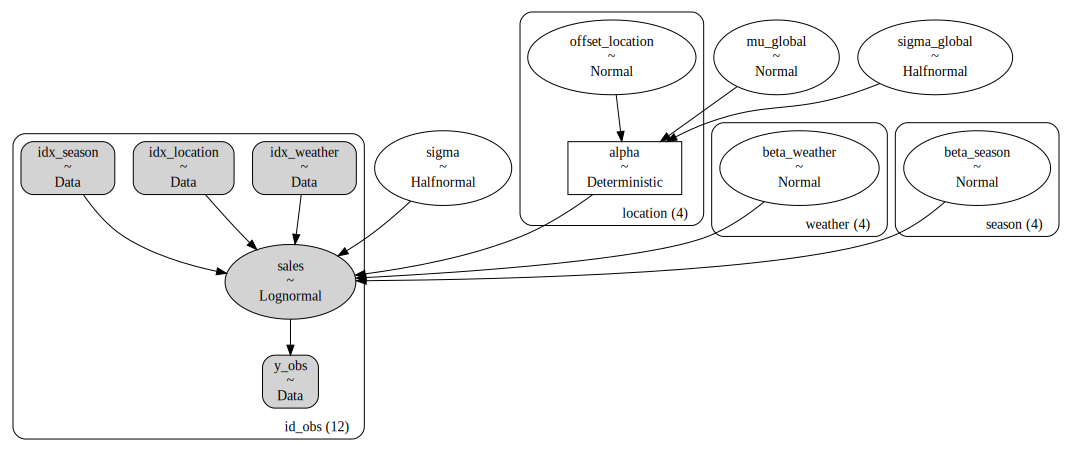

In [39]:
# モデルの構造の可視化
pm.model_to_graphviz(hierarchical_bayesian_linear_regression_model)

### 結果の解釈

#### ビジネス上の意味
このモデルによって、
- 雨の日でも売上が落ちにくい地点
- 特定の季節に強い地点

をデータが少ない中でもあぶりだそうとしています。季節ごとの人員配置や、天候による在庫リスク管理の精度を直接的に向上させ、無駄なコストを削減（ROIの向上）することに期待しています。

#### 技術的工夫
##### 非中心化パラメータ化 (Non-centered parameterization)
階層モデルにおいて `offset` を介して間接的に個別のパラメータ (`alpha`) を定義しています。
立地の売上をそのまま予測するのではなく、「全体の売上平均」と「そこからの立地の偏差値（ズレ）」に分けて計算するようなのです。
データが少ない地点でも、平均からのズレとして測ることで、予測が極端に外れるのを防げます。

#### 統計的根拠と分布の選択
##### 対数正規分布 (LogNormal)
売上データは「100万円の次は 120万円」といった「割合」で動くことが多く、またマイナスの売上は存在しません。そのため、対数をとると正規分布になる対数正規分布を選択しました。
- $\mu \sim Normal(11, 2^2)$
> 事前分布を最初から対数スケールの数値(11付近)で定義しておくことで、モデル全体が正しく「対数スケールの線形回帰」として機能します。
>
> 売上実績データの `sales_obs` は、おおよそ 40,000円～100,000円の範囲にあります。これを自然対数 (ln) に変換すると以下のようになります。
> - $\ln(40,000) \approx 10.6$
> - $\ln(100,000) \approx 11.5$
>
> コード内で `mu_global` の平均 (`mu`) を 11 に設定しているのは、「売上の中心が $e^{11} \approx 60,000$ 円くらいである」という事前知識を対数スケールで表現していることになります。
> もし、ここを `mu=60_000` としてしまうと、後の `LogNormal` 尤度 (Likelihood) と整合が取れず、計算が破綻します。


##### 事前分布の選択
`beta_weather` や `beta_season` に　`Normal(0, 0.5)` を指定しています。

- $\beta_{\text{weather}} \sim Normal(0, 0.5^2)$
- $\beta_{\text{season}} \sim Normal(0, 0.5^2)$

これは、対数スケールで ±0.5 (約0.6倍～1.6倍) 程度の変動が「もっともらしい」という、ビジネス感覚に近い弱情報事前分布 (Weakly Informative Prior) です。

> ##### 対数正規分布
> 変数 $x$ の対数 $ln(x)$ が正規分布に従う確率分布。正の値のみを取り、右側に長い裾（ロングテール）を持つのが特徴です。
> 「掛け算で決まる世界」の分布、というイメージで今回のように「客数 × 客単価」のように要素が掛け合わさって決まるため、平均的な日よりも「たまに大爆発する日」が出やすくなります。
> 正規分布（足し算の世界）ではこの「大爆発」を予測できません。

>##### 弱情報事前分布 (Weakly Informative Prior)
>ベイズ統計において
> - 実務的な妥当性
> - - データの尊重
>
>を両立させるための非常に賢いテクニックです。
>
> パラメータが取り得る「物理的・実務的に妥当な範囲」を緩やかに指定する分布です。
> モデルが計算不能な極端な値（異常な高値や負の値A）に迷い込むのを防ぎつつ、十分なデータがあればそのデータの結果を優先するように設計されます。
>
> 「経験上、売上はこのくらいになるはずだ（常識）」という意見は持っていますが、新しいデータが来れば柔軟に意見を変えることができ、ちょうど良いバランスの姿勢を持っているイメージです。
>
>分析者が「データを分析する前」に持っている知識の強さを、３つのパターンで可視化してみます。今回の売上予測モデルで $Normal(11, 2^2)$ を選んだ意図を明確にします。
>
>![事前分布の比較シミュレーション](img_weakly_info_prior.jpg)
>
>今回のモデルで**弱情報事前分布** を採用した理由は３つあります。
> 1. **正規化 (過学習の抑制)**: データが極端に少ない地点 (12件中の数件)でも、推定値が「無限大」や「ゼロ」に飛んでしまうのを防ぎます。
> 2. **計算の安定化**: 完全にフラットな「無情報分布」を使うと、MCMCサンプリングが広大な範囲を探索しすぎて計算が終わらなくなることがありますが、弱情報事前分布は探索範囲を「現実的な場所」に絞り込みます。
> 3. **対数スケールへの適合**: 売上を対数 (log) で扱う場合、平均 `11`　に対して標準偏差 `2` という設定は、元データのスケールで「数千円～数千万円」という広い範囲をカバーします。これは「常識外れな予測はしないが、可能性は広く残す」という理想的な設定です。
>
> SMB市場のような「スモールデータ」の環境では、**無情報分布 (何も知らない)** はむしろ危険になります。データが少ないと、たまたま起きたノイズを「真実」だと誤認してしまいます。
>
>弱情報事前分布を組み込むことで、**「過去の業界常識 (事前知識)」と「目の前の実績 (データ)」を数学的に正しく合算 (ベイズ更新)** でき、少ないデータからでもリスクの低い投資判断を下すことが可能になります。

>###### Tips
> もし「前回のキャンペーンでは売上が1.5倍になった」という確固たる過去の証拠がある場合は、弱情報から少し「強情報（SDを小さくする）」に寄せることで、より精度の高い予測が可能になります

In [ ]:
# TODO: 弱情報事前分布の説明を加筆